In [27]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")



In [28]:
from duckduckgo_search import DDGS
from itertools import islice
from fastcore.all import *

ddgs = DDGS()

def search_images(term, max_images = 30):
    print(f"searching for '{term}'")
    keywords = term
    ddgs_images = ddgs.images(keywords)
    limited_images = list(islice(ddgs_images, max_images))
    return L(limited_images).itemgot('image')

In [29]:
from time import sleep

def wait(seconds=10):
    total_seconds = seconds
    while seconds:
        progress_bar = "[" + "=" * (total_seconds - seconds) + " " * seconds + "]"
        sys.stdout.write(f"\r{seconds} seconds remaining {progress_bar}")
        time.sleep(1)
        seconds -= 1

    print("\n")

In [30]:
def throttle(func, wait_time=10, *args, **kwargs):
    func(*args, **kwargs)
    wait(wait_time)

In [72]:
path = Path('images')
from fastai.vision.all import *

In [32]:
def process_items(name, query_list, path):
    total_items = len(query_list)
    processed_items = 0

    for o in query_list:
        print("----", o, "----")
        
        dest = (path / o.split(" ")[0])

        print(dest)
        dest.mkdir(exist_ok=True, parents=True)
        
        # Assuming throttle, download_images, and resize_images are defined elsewhere
        throttle(download_images, dest=dest, urls=search_images(' '.join(o.split('_')) + ' photo'), wait_time=10)
        resize_images(dest, max_size=400, dest=dest)

        processed_items += 1
        progress_percentage = (processed_items / total_items) * 100
        print(f"\nProcessed {processed_items}/{total_items} items ({progress_percentage:.2f}%)")
        
        print("\n")

    print(f'{name} processing complete!')

In [33]:
pasta_shapes = [
    "spaghetti",
    "penne",
    "fettuccine",
    "rigatoni",
    "farfalle",
    "linguine",
    "ravioli",
    "lasagna",
    "rotini",
]
pasta_query_modifiers = ["cooked", "uncooked"]

pasta_queries = [[shape] + [f"{shape} {modifier}" for modifier in pasta_query_modifiers] for shape in pasta_shapes]
pasta_queries = [item for sublist in pasta_queries for item in sublist]

process_items('pasta', pasta_queries, path)

---- spaghetti ----
images/spaghetti
searching for 'spaghetti photo'


KeyboardInterrupt: 

In [34]:
not_pasta = [
    "rice", "quinoa", "couscous", 
    "bread", "pastries", "cookies", 
    "vegetables", "fruits", "salads", 
    "stir-fry dishes", "pizza", "sandwiches", 
    "kitchen utensils", "appliances", "cookware", 
    "furniture", "home decor", "office supplies", 
    "landscapes", "cityscapes", "forests", 
    "plants", "flowers", "trees", 
    "animals", "birds", "insects", 
    "abstract art", "patterns", "textures", 
    "fabric textures", "wood textures", "metal textures"
]

process_items('not_pasta', not_pasta, path)

---- rice ----
images/rice
searching for 'rice photo'


KeyboardInterrupt: 

In [35]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

len(failed)

67

In [36]:
def get_y(file_path):
    parent_folder = file_path.parent.name

    if parent_folder in pasta_shapes:
        return parent_folder
    else:
        return "not pasta"

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


NotImplementedError: The operator 'aten::_linalg_solve_ex.result' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

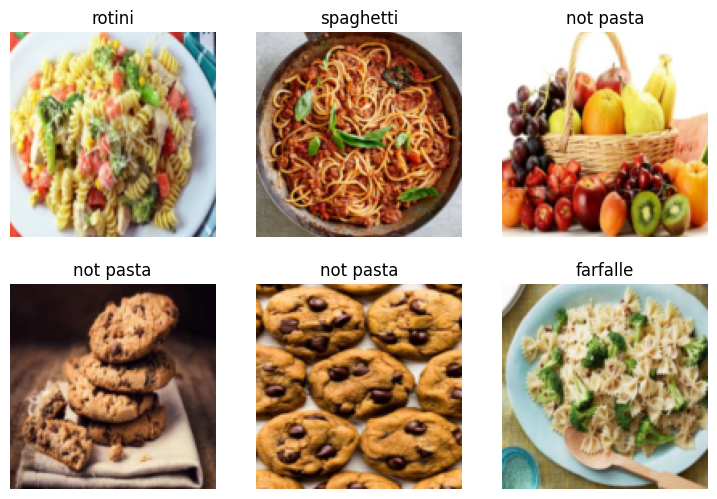

In [53]:
dataset = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_y,
    item_tfms=[RandomResizedCrop(128, min_scale=0.3)],
    # batch_tfms=aug_transforms(mult=2)
)

dls = dataset.dataloaders(path)

dataset = dataset.new(batch_tfms=aug_transforms())

dls.valid.show_batch(max_n=6)

dls = dataset.dataloaders(path)

In [54]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)


epoch,train_loss,valid_loss,error_rate,time
0,2.814039,1.452893,0.401392,00:11


epoch,train_loss,valid_loss,error_rate,time
0,1.405945,0.896763,0.243619,00:11
1,1.018493,0.622002,0.171694,00:11
2,0.773707,0.476392,0.116009,00:10
3,0.611043,0.469617,0.120650,00:10


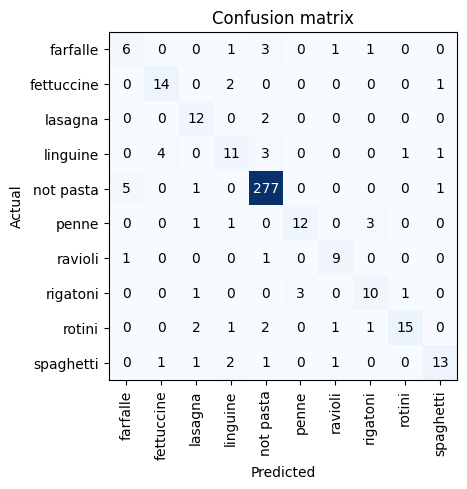

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


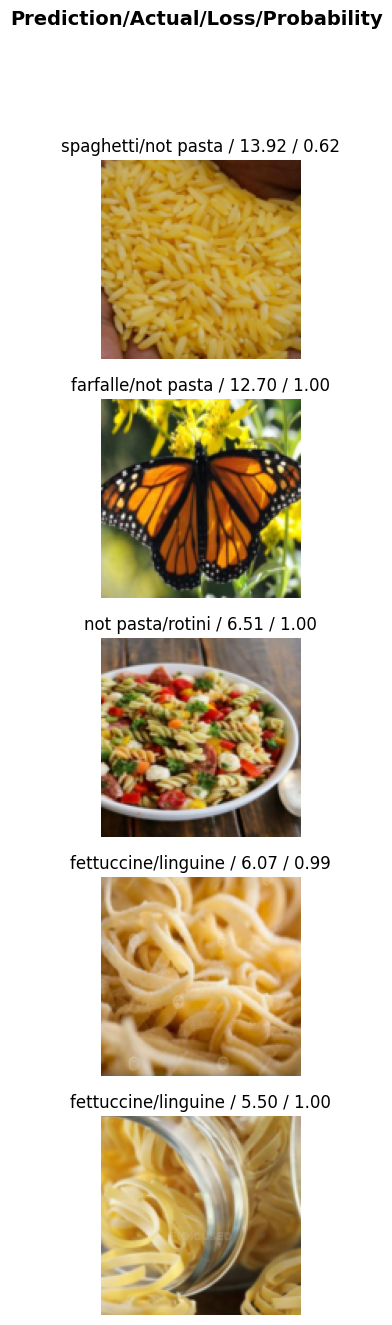

In [57]:
interp.plot_top_losses(5, nrows=5)

In [65]:
learn.export()



In [66]:
pkl_path = Path()
pkl_path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [69]:
learn_inf = load_learner(pkl_path/'export.pkl')

In [70]:
learn_inf.dls.vocab

['farfalle', 'fettuccine', 'lasagna', 'linguine', 'not pasta', 'penne', 'ravioli', 'rigatoni', 'rotini', 'spaghetti']

In [73]:
def count_files_in_subfolders(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            file_count = len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])
            print(f"Folder '{folder}' contains {file_count} files.")

count_files_in_subfolders(path)

Folder 'abstract' contains 27 files.
Folder 'wood' contains 28 files.
Folder 'home' contains 24 files.
Folder 'textures' contains 30 files.
Folder 'couscous' contains 60 files.
Folder 'landscapes' contains 29 files.
Folder 'trees' contains 29 files.
Folder 'patterns' contains 30 files.
Folder 'plants' contains 28 files.
Folder 'office' contains 25 files.
Folder 'vegetables' contains 54 files.
Folder 'metal' contains 28 files.
Folder 'rice' contains 88 files.
Folder 'linguine' contains 88 files.
Folder 'appliances' contains 58 files.
Folder 'ravioli' contains 87 files.
Folder 'flowers' contains 29 files.
Folder 'quinoa' contains 58 files.
Folder 'stir-fry' contains 58 files.
Folder 'cookware' contains 57 files.
Folder 'fettuccine' contains 83 files.
Folder 'furniture' contains 29 files.
Folder 'salads' contains 57 files.
Folder 'forests' contains 17 files.
Folder 'spaghetti' contains 110 files.
Folder 'sandwiches' contains 56 files.
Folder 'farfalle' contains 80 files.
Folder 'animals' 